# CS 584 Assignment 2 -- MLP and Word Vectors

#### Name: Mayank Raj
#### Stevens ID: 20010945

## Part B: Word2Vec (50 Points)

## In this assignment, you are required to follow the steps below:
1. Review the lecture slides.
2. Implement the data loading, preprocessing, tokenization, and word pair extraction.
3. Implement skip-gram and evaluation metrics with MLP.
5. Analysis the results in the Conlusion part.

**Before you start**
- Please read the code very carefully.
- Install these packages (jupyterlab, matplotlib, nltk, numpy, scikit-learn, tensorflow, tensorflow_addons) using the following command.
```console
pip install -r requirements.txt
```
- It's better to train the Tensorflow model with GPU and CUDA. If they are not available on your local machine, please consider Google CoLab. You can check `CoLab.md` in this assignments.
- You are **NOT** allowed to use other packages unless otherwise specified.
- You are **ONLY** allowed to edit the code between `# Start your code here` and `# End` for each block.

In [1]:
# you may not run this cell after the first installation
#!pip install -r requirements.txt

In [2]:
import tensorflow as tf


# If you are going to use GPU, make sure the GPU in in the output
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. Data Processing (5 points)

In [3]:
import sys


def print_line(*args):
    """ Inline print and go to the begining of line
    """
    args1 = [str(arg) for arg in args]
    str_ = ' '.join(args1)
    print('\r' + str_, end='')

In [4]:
from typing import List, Tuple, Union

import numpy as np

### 1.1 Load data

In [5]:
import os
import pickle

# In this imdb review, each line is a sentence seperated by a space.
sentences = pickle.load(open(os.path.join('a2-data', 'imdb_review.pickle'), 'rb'))
print(sentences[:10])

['watching time chasers it obvious that it was made by a bunch of friends', 'maybe they were sitting around one day in film school and said hey let s pool our money together and make a really bad movie or something like that', 'what ever they said they still ended up making a really bad movie dull story bad script lame acting poor cinematography bottom of the barrel stock music etc', 'all corners were cut except the one that would have prevented this film s release', 'life s like that', 'i saw this film about years ago and remember it as being particularly nasty', 'i believe it is based on a true incident a young man breaks into a nurses home and rapes tortures and kills various women it is in black and white but saves the colour for one shocking shot at the end the film seems to be trying to make some political statement but it just comes across as confused and obscene avoid', 'minor spoilersin new york joan barnard elvire audrey is informed that her husband the archeologist arthur ba

### 1.3 Tokenization (5 Points)

In this section, you will implement a Tokenizer than can record all tokens in a vocabulary.

In [58]:
class Tokenizer:
    def __init__(self, sos_token='<s>', eos_token='</s>', pad_token='<pad>', unk_token='<unk>', mask_token='<mask>'):
        # Special tokens. Not used in Word2Vec
        self.sos_token = sos_token
        self.eos_token = eos_token
        self.pad_token = pad_token
        self.unk_token = unk_token
        self.mask_token = mask_token
        
        self.vocab = { sos_token: 0, eos_token: 1, pad_token: 2, unk_token: 3, mask_token: 4 }  # token -> id
        self.inverse_vocab = { 0: sos_token, 1: eos_token, 2: pad_token, 3: unk_token, 4: mask_token }  # id -> token
        self.token_occurrence = { sos_token: 0, eos_token: 0, pad_token: 0, unk_token: 0, mask_token: 0 }  # token -> occurrence
        
    def __len__(self):
        """ A magic method that enable program to know the number of tokens by calling:
            ```python
            tokenizer = Tokenizer()
            num_tokens = len(tokenizer)
            ```
        """
        return len(self.vocab)

        
    def fit(self, sentences: List[str]):
        """ Fit the tokenizer using all sentences.
        1. Tokenize the sentence by splitting with spaces.
        2. Record the occurrence of all tokens
        3. Construct the token to index (self.vocab) map and the inversed map (self.inverse_vocab) based on the occurrence. The token with a higher occurrence has the smaller index
        
        Args:
            sentences: All sentences in the dataset.
        """
        n = len(sentences)
        for i, sentence in enumerate(sentences):
            if i % 100 == 0 or i == n - 1:
                print_line('Fitting Tokenizer:', (i + 1), '/', n)
            # Start your code here (Step 1 and 2)
                self.num_doc = len(sentences)        
            tokens = sentence.lower().split()
            for token in tokens:
                if token in self.token_occurrence:
                    self.token_occurrence[token] += 1
                else:
                    self.token_occurrence[token] = 1

            # End
        print_line('\n #####  ')
        # Start your code here (Step 3, update self.vocab and self.inverse_vocab)    
        for i, token in enumerate(self.token_occurrence.keys()):
            self.vocab[token] = i+5
            self.inverse_vocab[i+5] = token
        
        print(' end of fit')
        # End
        
        print('The number of distinct tokens:', len(self.vocab))
        
    def encode(self, sentences: List[str]) -> List[List[int]]:
        """ Encode the sentences into token ids
            Note: 1. if a token in a sentence does not exist in the fit encoder, we will use the <unk> token to replace it.
                  2. If the number of tokens in a sentence is less than two, we ignore this sentence.
        Args:
            sentences: Raw sentences
        Returns:
            sent_token_ids: A list of id list
        """
        n = len(sentences)
        sent_token_ids = []
        for i, sentence in enumerate(sentences):
            if i % 100 == 0 or i == n - 1:
                print_line('Encoding with Tokenizer:', (i + 1), '/', n)
            token_ids = []
            # Start your code (encode)
            token_ids = sentence.split()
            vocab_ids=[]
            for k in token_ids:
                vocab_ids.append(self.vocab[k])
            for tk in token_ids:
                if self.vocab.get(tk,-10)==-10:
                    tk='<unk>'
            if len(token_ids)>2:
                sent_token_ids.append(vocab_ids)
            # End
        return sent_token_ids

#### Test your implementation by running the following cell.

In [60]:
test_sentences = sentences[:2]
tokenizer = Tokenizer()
tokenizer.fit(test_sentences)
print()

token_occurrence = sorted(tokenizer.token_occurrence.items(), key=lambda e: e[1], reverse=True)
for token, occurrence in token_occurrence[:10]:
    print(token, ':', occurrence)
print()
sent_token_ids = tokenizer.encode(test_sentences)

for test_sentence, token_ids in zip(test_sentences, sent_token_ids):
    sentence = [tokenizer.inverse_vocab[token] for token in token_ids]
    print(test_sentence, sentence, '\n')

Fitting Tokenizer: 2 / 2
 #####   end of fit
The number of distinct tokens: 44

it : 2
that : 2
a : 2
and : 2
watching : 1
time : 1
chasers : 1
obvious : 1
was : 1
made : 1

Encoding with Tokenizer: 2 / 2watching time chasers it obvious that it was made by a bunch of friends ['watching', 'time', 'chasers', 'it', 'obvious', 'that', 'it', 'was', 'made', 'by', 'a', 'bunch', 'of', 'friends'] 

maybe they were sitting around one day in film school and said hey let s pool our money together and make a really bad movie or something like that ['maybe', 'they', 'were', 'sitting', 'around', 'one', 'day', 'in', 'film', 'school', 'and', 'said', 'hey', 'let', 's', 'pool', 'our', 'money', 'together', 'and', 'make', 'a', 'really', 'bad', 'movie', 'or', 'something', 'like', 'that'] 



Encode all sentences

In [61]:
tokenizer = Tokenizer()
tokenizer.fit(sentences)
sent_token_ids = tokenizer.encode(sentences)

# Note: if you implement correctly, there will be about 100k tokens.

Fitting Tokenizer: 528199 / 528199
 #####   end of fit
The number of distinct tokens: 102299
Encoding with Tokenizer: 528199 / 528199

In [9]:
print('max token number in a sentence:', max(map(lambda e: len(e), sent_token_ids)))
print('min token number in a sentence:', min(map(lambda e: len(e), sent_token_ids)))
print('avg token number in a sentence:', sum(map(lambda e: len(e), sent_token_ids)) / len(sent_token_ids))

max token number in a sentence: 767
min token number in a sentence: 3
avg token number in a sentence: 23.07580687218086


In [62]:
token_occurrence = sorted(tokenizer.token_occurrence.items(), key=lambda e: e[1], reverse=True)
for token, occurrence in token_occurrence[:10]:
    print(token, ':', occurrence)

the : 678333
and : 329979
a : 328341
of : 293903
to : 271514
is : 214380
it : 191411
in : 188920
i : 170761
this : 150693


## 2. Training Data Generation (10 Points)

### Positive Samples (5 Points)
In this section, you are required to generate the positive training data for skip-gram.

- Given a token sequence, for every center token, you need to use a window whose size is **2** to retrieve context words as positive pairs.
    
For example, given the token sequence "The quick brown fox jumps over the lazy dog .", when the center word is "fox", the context words are:
$$\text{The}~\underbrace{\text{quick brown}}_\text{context words}~\underbrace{\text{fox}}_{\text{center word}}~\underbrace{\text{jumps over}}_\text{context words}~\text{the lazy dog .}$$
We can generate four positive pairs: (fox, quick), (fox, brown), (fox, jumps), (fox, over).

In [66]:
import random


def concat(*iterables):
    for iterable in iterables:
        yield from iterable

def positive_pairs_generator(sent_token_ids: List[List[int]], window_size: int = 2) -> np.ndarray:
    """ Generate positive pairs: (center word, context word)
    
    Args:
        sent_token_ids: List of token list. Each element is a token list (sentence)
        window_size: the context window size. You should retrieve window size context words in the left and window size context words in the right.
        
    Yield:
        center_word, context_word: a positive pair
        
    Note: this is a generator function which yields pairs. Do not return anything.
    """
    n = len(sent_token_ids)
    for t, token_ids in enumerate(sent_token_ids):
        if t % 100 == 0 or t == n - 1:
            print_line('Positive Pair Generation:', (t + 1), '/', n)
    
        for i, center_word in enumerate(token_ids):
            context_words = []
            # Start your code here
            # Append context words of center_word to context_words
            l=len(token_ids)
            for j in range(l):
                if token_ids[j]!=center_word:
                    context_words.append(token_ids[j])                
            # End
            for context_word in context_words:
                yield center_word, context_word


def save_train_file(sent_token_ids: List[List[int]], window_size: int = 2):
    generator = positive_pairs_generator(sent_token_ids, window_size)
    buffer_size = 100000
    buffer = []
    count = 0
    with open(os.path.join('a2-data', 'word2vec_train_file.txt'), 'w') as train_file:
        for center_word, context_words in generator:
            count += 1
            line = f'{center_word} {context_words}\n'
            buffer.append(line)
            if len(buffer) == buffer_size:
                random.shuffle(buffer)
                train_file.writelines(buffer)
                buffer = []
        if len(buffer) > 0:
            train_file.writelines(buffer)
    print('\n')
    print(f'There are {count} pairs')
    return count

In [67]:
window_size = 2
num_samples = save_train_file(sent_token_ids, window_size)

# Note: if you implement correctly, there will be about 44M pairs.

Positive Pair Generation: 513898 / 513898

There are 438634942 pairs


### Negative Samples (5 Points)

We randomly select $K$ words from the vocabulary as negative samples.

In [68]:
def get_negative_samples(vocab_size: int, batch_size: int, negative_sample_num: int) -> np.ndarray:
    """ Generate negative words
    
    Args:
        vocab_size: number of tokens in the vocabulary
        batch_size: number of samples (center word) in a batch
        negative_sample_num: number of negative words sampled for a center word
        
    Return:
        negative_words: Shape of (batch_size x negative_sample_num)
        
    Note: 1. You should NOT sample special token in the vocabulary, i.e., the token ids range should be [5, vocab_size)
          2. Hint: See numpy.random.choice. Read carefully for each parameter of this function
    """
    
    negative_words = None
    # Start your code here
    negative_words = np.random.choice(np.arange(5,vocab_size), (batch_size,negative_sample_num))
    
    # End
    return negative_words


def train_data_generator(batch_size, vocab_size, negative_sample_num):
    with open(os.path.join('a2-data', 'word2vec_train_file.txt')) as train_file:
        while True:
            batch_center_words, batch_context_words = [], []
            for line in train_file:
                center_word, context_word = line.strip().split()
                batch_center_words.append(int(center_word))
                batch_context_words.append(int(context_word))
                if len(batch_center_words) == batch_size:
                    negative_words = get_negative_samples(vocab_size, batch_size, negative_sample_num)
                    yield batch_center_words, batch_context_words, negative_words
                    batch_center_words, batch_context_words = [], []
            train_file.seek(0)
            if len(batch_center_words) > 0:
                real_batch_size = len(batch_center_words)
                negative_words = get_negative_samples(vocab_size, real_batch_size, negative_sample_num)
                yield batch_center_words, batch_context_words, negative_words
            

## 3. Skip-gram Model (20 Points)

- Loss: 10 Points
- Model: 10 Points

In [76]:
from tensorflow.keras import Model
from tensorflow.keras.losses import Loss

def negative_sampling_loss(center_embeddings, context_embeddings, negative_embeddings):
    """ Calculate the negative sampling loss
    
    Args:
        center_embeddings: v_c, (batch_size x embedding_dim)
        context_embeddings: u_o, (batch_size x embedding_dim)
        negative_embeddings: u_k, (batch_size x negative_sample_num x embedding_dim)
    """
    loss = 0
    # Start your code here
    # 1. Calculate positive dot product
    # 2. loss for the positive pairs
    # 3. Calculate negative dot product
    # 4. loss for the negative words
    # Hint: See tf.reduce_sum, tf.expand_dims, tf.reduce_mean for help
    
    dot_product = tf.reduce_sum(tf.multiply(context_embeddings, center_embeddings), axis=1)
    positive = tf.nn.sigmoid(dot_product) #positive dot product
    loss_positive = tf.math.log(positive) #loss for positive pair
    
    center_embeddings = tf.expand_dims(center_embeddings, axis=1)
    dot_product = tf.reduce_sum(tf.multiply(negative_embeddings, center_embeddings), axis=2)
    negative = tf.nn.sigmoid(-dot_product) 
    loss_negative = tf.reduce_sum(tf.math.log(negative), axis=1) #loss for negative pair

    loss = -(tf.reduce_mean(loss_positive + loss_negative)) #net loss
    # End
    return loss

class SkipGram(Model):
    def __init__(self, vocab_size: int, embedding_dim: int):
        """ Skip-gram model.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        # Start your code here
        # Initialize embedding layers
        
        self.center_embeddings = tf.keras.layers.Embedding(vocab_size,
                                      embedding_dim,
                                      input_length=1,
                                      name="w2v_embedding")
        self.context_embeddings =tf.keras.layers.Embedding(vocab_size,
                                       embedding_dim,
                                       input_length=negative_sample_num+1)
        self.negative_embeddings=tf.keras.layers.Embedding(vocab_size,embedding_dim,
                                       input_length=negative_sample_num+1)
        # Hint: See tf.keras.layers.Embedding

        # End
        
    def call(self, center_words, context_words, negative_words):
        """ Forward of the skip-gram model
        
        Args:
            center_words: tensor (batch_size, )
            context_words: tensor (batch_size, )
            negative_words: tensor (batch_size, negative_embeddings)
            
        Return:
            center_embeddings, context_embeddings, negative_embeddings: The input for the negative_sampling_loss.
        """
        # Start your code here
        center_embeddings=self.center_embeddings(center_words)
        context_embeddings=self.context_embeddings(context_words)
        negative_embeddings=self.negative_embeddings(negative_words)

        # End
        
        return center_embeddings, context_embeddings, negative_embeddings

In [77]:
vocab_size = len(tokenizer)
embedding_dim = 64
num_epoch = 2
batch_size = 1024
negative_sample_num = 5

In [78]:
model = SkipGram(vocab_size, embedding_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [79]:
n_batch = int(np.ceil(num_samples / batch_size))
train_gen = train_data_generator(batch_size, vocab_size, negative_sample_num)
for epoch in range(num_epoch):
    epoch_loss = 0.0
    for batch_idx in range(n_batch):
        batch = next(train_gen)
        real_batch_size = len(batch[0])
        batch = [tf.convert_to_tensor(d, tf.int64) for d in batch]

        with tf.GradientTape() as tape:
            output = model(*batch)
            loss = negative_sampling_loss(*output)

        if batch_idx % 10 == 0 or batch_idx == num_samples - 1:
            print_line(f'Epoch {epoch + 1} / {num_epoch} - Step {batch_idx + 1} / {n_batch} - loss: {loss:.4f}')
            
        trainable_vars = model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        optimizer.apply_gradients(zip(gradients, trainable_vars))
        epoch_loss += loss * real_batch_size
    print(f'\rEpoch {epoch + 1} / {num_epoch} - Step {n_batch} / {n_batch} - loss: {epoch_loss / num_samples:.4f}')

Epoch 1 / 2 - Step 428355 / 428355 - loss: 0.01050
Epoch 2 / 2 - Step 428355 / 428355 - loss: 0.00010


## 4. Visualization (5 Points)

In [80]:
# word_vecs = tf.concat([model.center_embeddings.weights[0], model.context_embeddings.weights[0]], axis=-1).numpy()
center_vecs = model.center_embeddings.weights[0].numpy()
center_vecs.shape

(102299, 64)

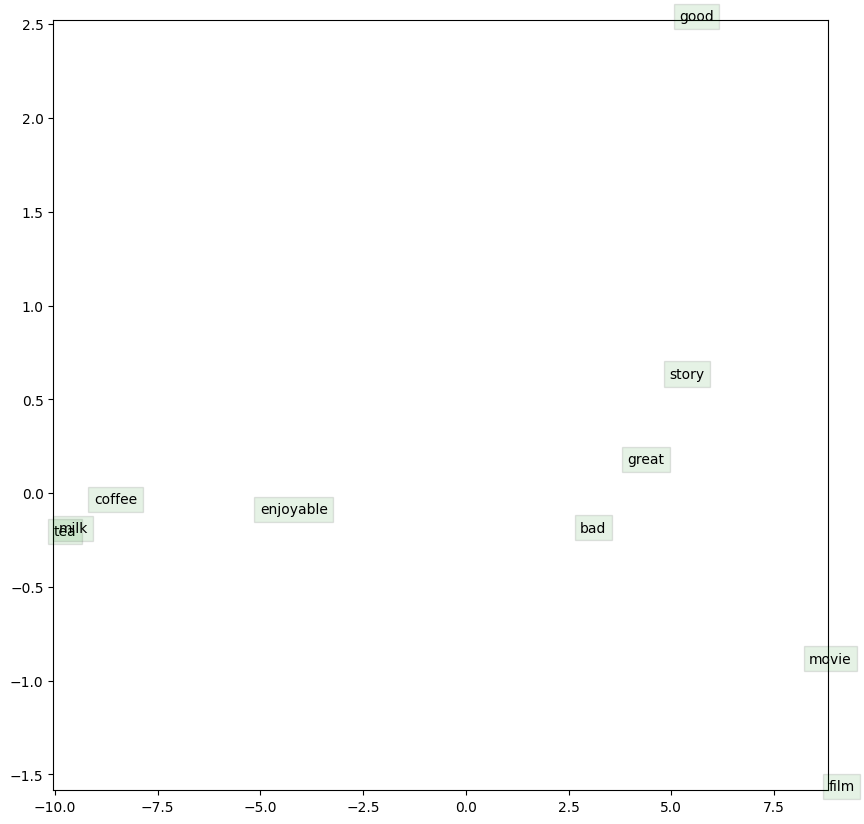

In [85]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

visualize_words = [
    "movie", "film", "story",
    "good", "enjoyable", "great", "bad",
    "coffee", "tea", "milk"
]
visualize_idx = [tokenizer.vocab[word] for word in visualize_words]
visualize_vecs = center_vecs[visualize_idx, :]

temp = (visualize_vecs - np.mean(visualize_vecs, axis=0))
covariance = 1.0 / len(visualize_idx) * temp.T.dot(temp)
U, S, V = np.linalg.svd(covariance)
coord = temp.dot(U[:, 0:2])

for i in range(len(visualize_words)):
    plt.text(coord[i, 0], coord[i, 1], visualize_words[i],
             bbox=dict(facecolor='green', alpha=0.1))

plt.xlim((np.min(coord[:, 0]), np.max(coord[:, 0])))
plt.ylim((np.min(coord[:, 1]), np.max(coord[:, 1])))

plt.savefig('word_vectors.png')
plt.show()

In [93]:
def knn(vec, mat, k):
    """ Implement the KNN algorithm based on cosine similarity, which will be used for analysis.

        Args:
            vec: numpy ndarray, the target vector
            mat: numpy ndarray, a matrix contains all the vectors (each row is a vector)
            k: the number of the nearest neighbors you want to find.
            
        Return:
            indices: the k indices of the matrix's rows that are closest to the vec
    """
    indicies = []
    def cosine_similarity(vector_1: np.ndarray, vector_2: np.ndarray) -> float:
    
        return np.dot(vector_1, vector_2)/(np.linalg.norm(vector_1) *
                                          np.linalg.norm(vector_2))
    # Start your code here
    # Note: DO NOT use for loop to calculate the similarity between two vectors. You are required to vectorize the calculation.
    # Hint: See np.argsort
    indices=np.argsort([cosine_similarity(vec, row)
                          for row in mat])[-k:]

    # End
    
    return indices

In [94]:
for word in visualize_words:
    idx = tokenizer.vocab[word]
    vec = center_vecs[idx]
    indices = knn(vec, center_vecs, 10)
    closed_words = [tokenizer.inverse_vocab[i] for i in indices]
    print('Word: "{}" is close to {}'.format(word, closed_words))

Word: "movie" is close to ['rothrock', 'staggers', 'crown', 'quarrel', 'assumption', 'tributes', 'harlot', 'ingenue', 'sculpted', 'movie']
Word: "film" is close to ['performing', 'topaz', 'damascus', 'achieve', 'jacob', 'psychopaths', 'planks', 'shrug', 'softens', 'film']
Word: "story" is close to ['matheson', 'rounds', 'depending', 'manual', 'miscommunication', 'succumbed', 'weasel', 'missing', 'loosing', 'story']
Word: "good" is close to ['killings', 'effective', 'garr', 'inherits', 'duffy', 'spike', 'mates', 'pictures', 'concert', 'good']
Word: "enjoyable" is close to ['schwarzenegger', 'awry', 'transcends', 'akins', 'pleasures', 'argue', 'unwanted', 'firing', 'highlander', 'enjoyable']
Word: "great" is close to ['unrealistically', 'insulted', 'mere', 'hijack', 'croatia', 'alcatraz', 'milius', 'carroll', 'posh', 'great']
Word: "bad" is close to ['rojo', 'liabilities', 'absurd', 'disguise', 'flows', 'tug', 'odious', 'dosed', 'dictated', 'bad']
Word: "coffee" is close to ['occupies', 

## 5. Conclusion (5 Points)

Provide an analysis for all the results

1)- Negative sampling loss significantly brings down the computation cost and time.

2)- Use of iterators is more memory efficient and helps with large datasets. 

2)-Similarity between terms in knn based algorithm is calculated using cosine function which is more accurate than euclidean distance for text data